# DDSIM vs Qiskit Aer

In [1]:
import time
import random

import matplotlib.pyplot as plt
from mqt import ddsim
import numpy as np
import qiskit
import qiskit_aer

## One case

### Create the target circuits

In [2]:
num_state_qubits = 13
circuit = qiskit.circuit.library.DraperQFTAdder(num_state_qubits)

# ==========
a = 7
b = 5
# ==========
a_bin = bin(a)[2:]
b_bin = bin(b)[2:]
out_bin = bin(a + b)[2:]
print(f"a + b = {a} + {b} = {int(out_bin, 2)}")

for index, letter in enumerate(a_bin[::-1]):
    if letter == "1":
        circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)
for index, letter in enumerate(b_bin[::-1], num_state_qubits):
    if letter == "1":
        circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)

# circuit.draw()

a + b = 7 + 5 = 12


### Define utils

In [3]:
SEED = 901

In [4]:
def convert_counts(original_counts):
    return {int(value, 16): original_counts[value] for value in original_counts}

In [5]:
def get_transpiled(backend):
    pass_manager = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=3,
        backend=backend,
        seed_transpiler=SEED,
    )

    trainspiled_circuit = pass_manager.run(circuit)  # Use the circuit defined above

    trainspiled_circuit.add_register(qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits))
    trainspiled_circuit.measure(trainspiled_circuit.qregs[-1], trainspiled_circuit.cregs[0])
    
    return trainspiled_circuit

In [6]:
def run(backend):
    assert SEED == backend.options.seed_simulator
    transpiled_circuit = get_transpiled(backend)
    
    job = backend.run(transpiled_circuit, shots=8192)

    return job

### Check the backends

In [7]:
ddsim.DDSIMProvider().backends()

In [8]:
qiskit_aer.AerProvider().backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

### QASM

#### AerSimulator

In [9]:
aer_qasm = qiskit_aer.AerSimulator(seed_simulator=SEED)
aer_qasm_job = run(aer_qasm)

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit DraperQFTAdder using the statevector simulator. Required memory: 32768M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit DraperQFTAdder using the statevector simulator. Required memory: 32768M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit DraperQFTAdder using the statevector simulator. Required memory: 32768M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit DraperQFTAdder using the statevector simulator. Required memory: 32768M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit DraperQFTAdder using the statevector simul

In [10]:
print(aer_qasm_job.status())
print(convert_counts(aer_qasm_job.result().results[0].data.counts))
aer_qasm_job.result().results[0].metadata["time_taken"]

JobStatus.DONE
{12: 8192}


17.62129125

#### Among DDSIM

##### `QasmSimulatorBackend`

In [11]:
ddsim_qasm = ddsim.qasmsimulator.QasmSimulatorBackend()
ddsim_qasm.options.update_options(seed_simulator=SEED)

ddsim_qasm_job = run(ddsim_qasm)

In [12]:
print(ddsim_qasm_job.status())
print(convert_counts(ddsim_qasm_job.result().results[0].data.counts))
ddsim_qasm_job.result().results[0].data.time_taken

JobStatus.DONE
{12: 8192}


0.010968923568725586

##### `HybridQasmSimulatorBackend`
`MemoryError: std::bad_alloc` arises.

In [13]:
# ddsim_hybrid_qasm = ddsim.hybridqasmsimulator.HybridQasmSimulatorBackend()
# ddsim_hybrid_qasm.options.update_options(seed_simulator=SEED)
# 1
# ddsim_hybrid_qasm_job = run(ddsim_hybrid_qasm)

In [14]:
# print(convert_counts(ddsim_hybrid_qasm_job.result().results[0].data.counts))
# ddsim_qasm_job.result().results[0].data.time_taken

##### `PathQasmSimulatorBackend`
`MemoryError: std::bad_alloc` arises.

In [15]:
# ddsim_path_qasm = ddsim.pathqasmsimulator.PathQasmSimulatorBackend()
# ddsim_path_qasm.options.update_options(seed_simulator=SEED)

# ddsim_path_qasm_job = run(ddsim_hybrid_qasm)

In [16]:
# print(convert_counts(ddsim_path_qasm_job.result().results[0].data.counts))
# ddsim_path_qasm_job.result().results[0].data.time_taken

## Comprehensive Analysis

### Increase in the number of qubtis

In [17]:
def get_circuit(num_state_qubits, a, b):
    circuit = qiskit.circuit.library.DraperQFTAdder(num_state_qubits, kind='half')

    a_bin = bin(a)[2:]
    b_bin = bin(b)[2:]
    out_bin = bin(a + b)[2:]
    # print(f"a + b = {a} + {b} = {int(out_bin, 2)}")
    
    for index, letter in enumerate(a_bin[::-1]):
        if letter == "1":
            circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)
    for index, letter in enumerate(b_bin[::-1], num_state_qubits):
        if letter == "1":
            circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)

    return circuit

In [18]:
SEED = 901
SHOTS = 8192

def convert_counts(original_counts):
    return {int(value, 16): original_counts[value] for value in original_counts}

In [19]:
aer_qasm = qiskit_aer.AerSimulator(seed_simulator=SEED)

ddsim_qasm = ddsim.qasmsimulator.QasmSimulatorBackend()
ddsim_qasm.options.update_options(seed_simulator=SEED)

In [20]:
%%time
random.seed(SEED)

max_num_state_qubits = 15
num_trials = 10

aer_jobs = dict()
ddsim_jobs = dict()
for num_state_qubits in range(1, max_num_state_qubits+1):
    for _ in range(num_trials):
        max_number = (2 ** num_state_qubits) - 1
        a = random.randint(0, max_number)
        b = random.randint(0, max_number)
        
        # Get the target circuit.
        circuit = get_circuit(num_state_qubits, a, b)
        
        # Make the key for the dicts.
        result = a + b
        key = (circuit.num_qubits, num_trials, a, b, result)
    
        # Transpile the circuit for Aer.
        pass_manager = qiskit.transpiler.generate_preset_pass_manager(
            optimization_level=3,
            backend=aer_qasm,
            seed_transpiler=SEED,
        )
        trainspiled_circuit_for_aer = pass_manager.run(circuit)
        trainspiled_circuit_for_aer.add_register(
            qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits)
        )
        for c_index in range(trainspiled_circuit_for_aer.num_qubits - num_state_qubits):
            q_index = c_index + num_state_qubits
            trainspiled_circuit_for_aer.measure(q_index, c_index)
        # Run the circuit with Aer.
        job = aer_qasm.run(trainspiled_circuit_for_aer, shots=SHOTS)
        aer_jobs[key] = job
    
        # Transpile the circuit for DDSIM.
        pass_manager = qiskit.transpiler.generate_preset_pass_manager(
            optimization_level=3,
            backend=ddsim_qasm,
            seed_transpiler=SEED,
        )
        trainspiled_circuit_for_ddsim = pass_manager.run(circuit)
        trainspiled_circuit_for_ddsim.add_register(
            qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits)
        )
        for c_index in range(trainspiled_circuit_for_ddsim.num_qubits - num_state_qubits):
            q_index = c_index + num_state_qubits
            trainspiled_circuit_for_ddsim.measure(q_index, c_index)
        # Run the circuit with DDSIM.
        job = ddsim_qasm.run(trainspiled_circuit_for_ddsim, shots=SHOTS)
        ddsim_jobs[key] = job

CPU times: user 3h 45min 15s, sys: 40min 14s, total: 4h 25min 29s
Wall time: 46min 14s


In [21]:
# Define functions to organise data.
def get_success_possibility(job, true_key_digit, shots=SHOTS):
    counts_digit = convert_counts(job.result().results[0].data.counts)
    return counts_digit[true_key_digit] / shots

def get_time_taken_from_aer(job):
    return job.result().results[0].metadata["time_taken"]

def get_time_taken_from_ddsim(job):
    return job.result().results[0].data.time_taken

In [22]:
# Organise the data for Aer.
aer_results = dict()
for key, aer_job in aer_jobs.items():
    num_qubits = key[0]
    if num_qubits not in aer_results:
        aer_results[num_qubits] = {"success_possibilities": [], "time_taken": []}

    if not aer_job.result().results[0].success:
        continue
    true_key_digit = key[-1]
    aer_results[num_qubits]["success_possibilities"].append(get_success_possibility(aer_job, true_key_digit))
    aer_results[num_qubits]["time_taken"].append(get_time_taken_from_aer(aer_job))

aer_result = [
    (num_qubits,
     float(np.mean(aer_results[num_qubits]["success_possibilities"])),
     float(np.mean(aer_results[num_qubits]["time_taken"])),
    )
    for num_qubits in aer_results.keys()
]
aer_result

/Users/ksk/.pyenv/versions/3.13.2/envs/backend_comparison/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ksk/.pyenv/versions/3.13.2/envs/backend_comparison/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[(3, 1.0, 0.0036428750000000003),
 (5, 1.0, 0.004889184714285714),
 (7, 1.0, 0.007109657555555556),
 (9, 1.0, 0.013463995222222223),
 (11, 1.0, 0.0238200498),
 (13, 1.0, 0.024150716699999998),
 (15, 1.0, 0.011383054100000001),
 (17, 1.0, 0.03261872910000001),
 (19, 1.0, 0.08985978339999999),
 (21, 1.0, 0.4002887958),
 (23, 1.0, 1.8510963083),
 (25, 1.0, 8.0073361001),
 (27, 1.0, 35.5083436335),
 (29, 1.0, 228.76088200429996),
 (31, nan, nan)]

In [23]:
# Organise the data for DDSIM.
ddsim_results = dict()
for key, ddsim_job in ddsim_jobs.items():
    num_qubits = key[0]
    if num_qubits not in ddsim_results:
        ddsim_results[num_qubits] = {"success_possibilities": [], "time_taken": []}

    if not ddsim_job.result().results[0].success:
        continue
    
    true_key_digit = key[-1]
    ddsim_results[num_qubits]["success_possibilities"].append(get_success_possibility(ddsim_job, true_key_digit))
    ddsim_results[num_qubits]["time_taken"].append(get_time_taken_from_ddsim(ddsim_job))

ddsim_result = [
    (num_qubits,
     float(np.mean(ddsim_results[num_qubits]["success_possibilities"])),
     float(np.mean(ddsim_results[num_qubits]["time_taken"])),
    )
    for num_qubits in ddsim_results.keys()
]
ddsim_result

[(3, 1.0, 0.0036759376525878906),
 (5, 1.0, 0.003980977194649833),
 (7, 1.0, 0.004554589589436849),
 (9, 1.0, 0.0054327381981743705),
 (11, 1.0, 0.006635189056396484),
 (13, 1.0, 0.012125802040100098),
 (15, 1.0, 0.014391422271728516),
 (17, 1.0, 0.015348362922668456),
 (19, 1.0, 0.01678755283355713),
 (21, 1.0, 0.01918771266937256),
 (23, 1.0, 0.021355390548706055),
 (25, 1.0, 0.02190370559692383),
 (27, 1.0, 0.022709059715270995),
 (29, 1.0, 0.024019289016723632),
 (31, 1.0, 0.017694735527038576)]

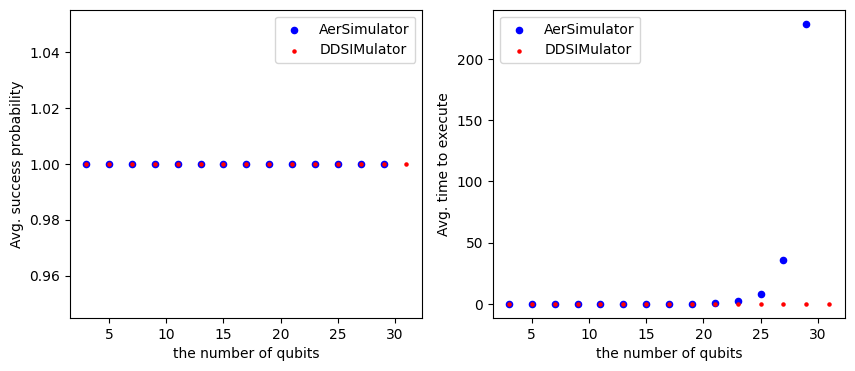

In [24]:
assert [num_qubits  for num_qubits, _, _ in aer_result] == [num_qubits  for num_qubits, _, _ in ddsim_result]
x = [num_qubits  for num_qubits, _, _ in aer_result]
success_possibilities_aer = [success_possibility  for _, success_possibility, _ in aer_result]
success_possibilities_ddsim = [success_possibility  for _, success_possibility, _ in ddsim_result]
times_taken_aer = [time_taken  for _, _, time_taken in aer_result]
times_taken_ddsim = [time_taken  for _, _, time_taken in ddsim_result]

fig, axes = plt.subplots(ncols=2, figsize=(10,4))

# Success probability
axes[0].scatter(x, success_possibilities_aer, color="blue", s=20, label="AerSimulator")
axes[0].scatter(x, success_possibilities_ddsim, color="red", s=5, label="DDSIMulator")
axes[0].set_xlabel("the number of qubits")
axes[0].set_ylabel("Avg. success probability")
axes[0].legend()

# Time taken
axes[1].scatter(x, times_taken_aer, color="blue", s=20, label="AerSimulator")
axes[1].scatter(x, times_taken_ddsim, color="red", s=5, label="DDSIMulator")
axes[1].set_xlabel("the number of qubits")
axes[1].set_ylabel("Avg. time to execute")
axes[1].legend()

plt.savefig("ddsim_vs_aer_qubits.png")

plt.show()

In [25]:
%%time
random.seed(SEED)

additional_max_num_state_qubits = 42
num_trials = 10

additional_ddsim_jobs = dict()
for num_state_qubits in range(max_num_state_qubits+1, additional_max_num_state_qubits+1):
    for _ in range(num_trials):
        max_number = (2 ** num_state_qubits) - 1
        a = random.randint(0, max_number)
        b = random.randint(0, max_number)
        
        # Get the target circuit.
        circuit = get_circuit(num_state_qubits, a, b)
        
        # Make the key for the dicts.
        result = a + b
        key = (circuit.num_qubits, num_trials, a, b, result)

        # Transpile the circuit for DDSIM.
        pass_manager = qiskit.transpiler.generate_preset_pass_manager(
            optimization_level=3,
            backend=ddsim_qasm,
            seed_transpiler=SEED,
        )
        trainspiled_circuit_for_ddsim = pass_manager.run(circuit)
        trainspiled_circuit_for_ddsim.add_register(
            qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits)
        )
        for c_index in range(trainspiled_circuit_for_ddsim.num_qubits - num_state_qubits):
            q_index = c_index + num_state_qubits
            trainspiled_circuit_for_ddsim.measure(q_index, c_index)
        # Run the circuit with DDSIM.
        job = ddsim_qasm.run(trainspiled_circuit_for_ddsim, shots=SHOTS)
        additional_ddsim_jobs[key] = job

CPU times: user 1min 54s, sys: 1.76 s, total: 1min 56s
Wall time: 1min 56s


In [26]:
# Organise the data for DDSIM.
additional_ddsim_results = dict()
for key, ddsim_job in additional_ddsim_jobs.items():
    num_qubits = key[0]
    if num_qubits not in additional_ddsim_results:
        additional_ddsim_results[num_qubits] = {"success_possibilities": [], "time_taken": []}

    if not ddsim_job.result().results[0].success:
        continue
    
    true_key_digit = key[-1]
    additional_ddsim_results[num_qubits]["success_possibilities"].append(get_success_possibility(ddsim_job, true_key_digit))
    additional_ddsim_results[num_qubits]["time_taken"].append(get_time_taken_from_ddsim(ddsim_job))

additional_ddsim_result = [
    (num_qubits,
     float(np.mean(additional_ddsim_results[num_qubits]["success_possibilities"])),
     float(np.mean(additional_ddsim_results[num_qubits]["time_taken"])),
    )
    for num_qubits in additional_ddsim_results.keys()
]
additional_ddsim_result

[(33, 1.0, 0.021108174324035646),
 (35, 1.0, 0.021666574478149413),
 (37, 1.0, 0.023452186584472658),
 (39, 1.0, 0.024164819717407228),
 (41, 1.0, 0.02554032802581787),
 (43, 1.0, 0.027539753913879396),
 (45, 1.0, 0.02909531593322754),
 (47, 1.0, 0.03026413917541504),
 (49, 1.0, 0.029937887191772462),
 (51, 1.0, 0.03099977970123291),
 (53, 1.0, 0.035210037231445314),
 (55, 1.0, 0.035664701461791994),
 (57, 1.0, 0.04012994766235352),
 (59, 1.0, 0.044756603240966794),
 (61, 1.0, 0.046376514434814456),
 (63, 1.0, 0.05042011737823486),
 (65, 1.0, 0.049952125549316405),
 (67, 1.0, 0.05190255641937256),
 (69, 1.0, 0.05526742935180664),
 (71, 1.0, 0.05931501388549805),
 (73, 1.0, 0.06184267997741699),
 (75, 1.0, 0.06470041275024414),
 (77, 1.0, 0.07672412395477295),
 (79, 1.0, 0.16225008964538573),
 (81, 1.0, 0.36897706985473633),
 (83, 1.0, 1.0299203157424928),
 (85, 1.0, 1.7897029161453246)]

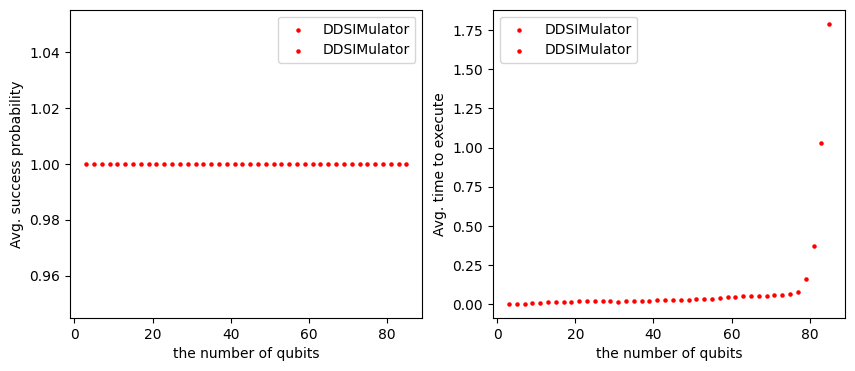

In [27]:
x = [num_qubits for num_qubits, _, _ in ddsim_result]
additional_x = [num_qubits for num_qubits, _, _ in additional_ddsim_result]
new_x = x + additional_x

success_possibilities_ddsim = [success_possibility  for _, success_possibility, _ in ddsim_result]
times_taken_ddsim = [time_taken  for _, _, time_taken in ddsim_result]

additional_success_possibilities_ddsim = [success_possibility  for _, success_possibility, _ in additional_ddsim_result]
additional_times_taken_ddsim = [time_taken  for _, _, time_taken in additional_ddsim_result]

new_success_possibilities_ddsim = success_possibilities_ddsim + additional_success_possibilities_ddsim
new_times_taken_ddsim = times_taken_ddsim + additional_times_taken_ddsim

fig, axes = plt.subplots(ncols=2, figsize=(10,4))

# Success probability
axes[0].scatter(new_w, new_success_possibilities_ddsim, color="red", s=5, label="DDSIMulator")
axes[0].set_xlabel("the number of qubits")
axes[0].set_ylabel("Avg. success probability")
axes[0].legend()

# Time taken
axes[1].scatter(new_x, new_times_taken_ddsim, color="red", s=5, label="DDSIMulator")
axes[1].set_xlabel("the number of qubits")
axes[1].set_ylabel("Avg. time to execute")
axes[1].legend()

plt.savefig("additional_ddsim_qubits.png")

plt.show()

### Increase in the number of adder

In [28]:
def get_deep_circuit(num_state_qubits, a, b, depth):
    if depth <= 0:
        depth = 1

    circuit = qiskit.circuit.library.DraperQFTAdder(num_state_qubits, kind='half')

    a_bin = bin(a)[2:]
    b_bin = bin(b)[2:]
    out_bin = bin(a + b)[2:]
    # print(f"a + b = {a} + {b} = {int(out_bin, 2)}")
    
    for index, letter in enumerate(a_bin[::-1]):
        if letter == "1":
            circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)
    for index, letter in enumerate(b_bin[::-1], num_state_qubits):
        if letter == "1":
            circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)

    for _ in range(depth - 1):
        circuit.compose(qiskit.circuit.library.DraperQFTAdder(num_state_qubits, kind='half'), range(circuit.num_qubits), inplace=True)

    return circuit

In [29]:
%%time
random.seed(SEED)

num_state_qubits = 10
max_depth = 20
num_trials = 10

aer_jobs = dict()
ddsim_jobs = dict()
for depth in range(1, max_depth + 1):
    for _ in range(num_trials):
        max_number = (2 ** num_state_qubits) - 1
        a = random.randint(0, max_number)
        b = random.randint(0, max_number)
        
        # Get the target circuit.
        circuit = get_deep_circuit(num_state_qubits, a, b, depth)
        
        # Make the key for the dicts.
        result = (a * depth + b) % (2 ** (num_state_qubits + 1))
        key = (depth, num_trials, a, b, result)
    
        # Transpile the circuit for Aer.
        pass_manager = qiskit.transpiler.generate_preset_pass_manager(
            optimization_level=3,
            backend=aer_qasm,
            seed_transpiler=SEED,
        )
        trainspiled_circuit_for_aer = pass_manager.run(circuit)
        trainspiled_circuit_for_aer.add_register(
            qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits)
        )
        for c_index in range(trainspiled_circuit_for_aer.num_qubits - num_state_qubits):
            q_index = c_index + num_state_qubits
            trainspiled_circuit_for_aer.measure(q_index, c_index)
        # Run the circuit with Aer.
        job = aer_qasm.run(trainspiled_circuit_for_aer, shots=SHOTS)
        aer_jobs[key] = job
    
        # Transpile the circuit for DDSIM.
        pass_manager = qiskit.transpiler.generate_preset_pass_manager(
            optimization_level=3,
            backend=ddsim_qasm,
            seed_transpiler=SEED,
        )
        trainspiled_circuit_for_ddsim = pass_manager.run(circuit)
        trainspiled_circuit_for_ddsim.add_register(
            qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits)
        )
        for c_index in range(trainspiled_circuit_for_ddsim.num_qubits - num_state_qubits):
            q_index = c_index + num_state_qubits
            trainspiled_circuit_for_ddsim.measure(q_index, c_index)
        # Run the circuit with DDSIM.
        job = ddsim_qasm.run(trainspiled_circuit_for_ddsim, shots=SHOTS)
        ddsim_jobs[key] = job

CPU times: user 1h 34min 58s, sys: 5min 39s, total: 1h 40min 38s
Wall time: 15min 25s


In [30]:
# Organise the data for Aer.
aer_results = dict()
for key, aer_job in aer_jobs.items():
    num_qubits = key[0]
    if num_qubits not in aer_results:
        aer_results[num_qubits] = {"success_possibilities": [], "time_taken": []}

    if not aer_job.result().results[0].success:
        continue

    true_key_digit = key[-1]
    aer_results[num_qubits]["success_possibilities"].append(get_success_possibility(aer_job, true_key_digit))
    aer_results[num_qubits]["time_taken"].append(get_time_taken_from_aer(aer_job))

aer_result = [
    (num_qubits,
     float(np.mean(aer_results[num_qubits]["success_possibilities"])),
     float(np.mean(aer_results[num_qubits]["time_taken"])),
    )
    for num_qubits in aer_results.keys()
]
aer_result

[(1, 1.0, 0.41506099170000005),
 (2, 1.0, 0.7622788792),
 (3, 1.0, 1.1272006376),
 (4, 1.0, 1.4795302581999998),
 (5, 1.0, 1.8106534789000002),
 (6, 1.0, 2.2391994624),
 (7, 1.0, 2.6463375208000004),
 (8, 1.0, 3.08274945),
 (9, 1.0, 3.4461228375),
 (10, 1.0, 3.6225337249),
 (11, 1.0, 3.858256746000001),
 (12, 1.0, 4.2248221500000005),
 (13, 1.0, 4.602815487500001),
 (14, 1.0, 4.8831777250999995),
 (15, 1.0, 5.305160933400001),
 (16, 1.0, 5.614708137599999),
 (17, 1.0, 5.9760368085),
 (18, 1.0, 6.284256437600001),
 (19, 1.0, 6.663836083600001),
 (20, 1.0, 7.2525995)]

In [31]:
# Organise the data for DDSIM.
ddsim_results = dict()
for key, ddsim_job in ddsim_jobs.items():
    num_qubits = key[0]
    if num_qubits not in ddsim_results:
        ddsim_results[num_qubits] = {"success_possibilities": [], "time_taken": []}

    if not ddsim_job.result().results[0].success:
        continue
    
    true_key_digit = key[-1]
    ddsim_results[num_qubits]["success_possibilities"].append(get_success_possibility(ddsim_job, true_key_digit))
    ddsim_results[num_qubits]["time_taken"].append(get_time_taken_from_ddsim(ddsim_job))

ddsim_result = [
    (num_qubits,
     float(np.mean(ddsim_results[num_qubits]["success_possibilities"])),
     float(np.mean(ddsim_results[num_qubits]["time_taken"])),
    )
    for num_qubits in ddsim_results.keys()
]
ddsim_result

[(1, 1.0, 0.021367812156677247),
 (2, 1.0, 0.018986988067626952),
 (3, 1.0, 0.022952866554260255),
 (4, 1.0, 0.023298120498657225),
 (5, 1.0, 0.025855612754821778),
 (6, 1.0, 0.030089545249938964),
 (7, 1.0, 0.03085799217224121),
 (8, 1.0, 0.02994699478149414),
 (9, 1.0, 0.028842353820800783),
 (10, 1.0, 0.030142498016357423),
 (11, 1.0, 0.02930305004119873),
 (12, 1.0, 0.030350780487060545),
 (13, 1.0, 0.030856966972351074),
 (14, 1.0, 0.032050251960754395),
 (15, 1.0, 0.03344390392303467),
 (16, 1.0, 0.03674812316894531),
 (17, 1.0, 0.0369370698928833),
 (18, 1.0, 0.037326622009277347),
 (19, 1.0, 0.038136410713195804),
 (20, 1.0, 0.03825359344482422)]

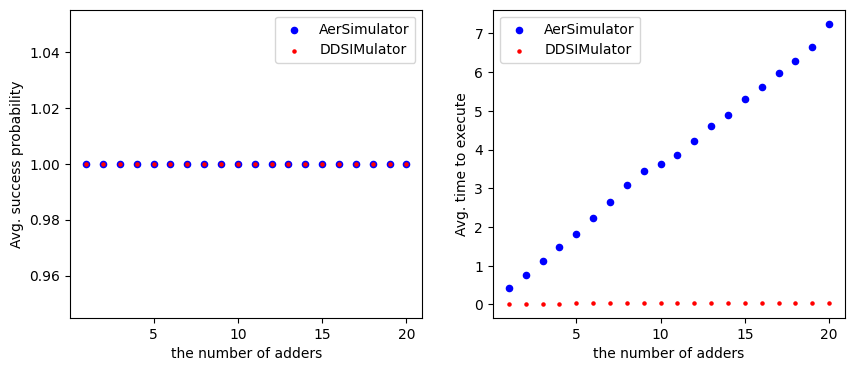

In [32]:
assert [num_qubits  for num_qubits, _, _ in aer_result] == [num_qubits  for num_qubits, _, _ in ddsim_result]
x = [num_qubits  for num_qubits, _, _ in aer_result]
success_possibilities_aer = [success_possibility  for _, success_possibility, _ in aer_result]
success_possibilities_ddsim = [success_possibility  for _, success_possibility, _ in ddsim_result]
times_taken_aer = [time_taken  for _, _, time_taken in aer_result]
times_taken_ddsim = [time_taken  for _, _, time_taken in ddsim_result]

fig, axes = plt.subplots(ncols=2, figsize=(10,4))

# Success probability
axes[0].scatter(x, success_possibilities_aer, color="blue", s=20, label="AerSimulator")
axes[0].scatter(x, success_possibilities_ddsim, color="red", s=5, label="DDSIMulator")
axes[0].set_xlabel("the number of adders")
axes[0].set_ylabel("Avg. success probability")
axes[0].legend()

# Time taken
axes[1].scatter(x, times_taken_aer, color="blue", s=20, label="AerSimulator")
axes[1].scatter(x, times_taken_ddsim, color="red", s=5, label="DDSIMulator")
axes[1].set_xlabel("the number of adders")
axes[1].set_ylabel("Avg. time to execute")
axes[1].legend()

plt.savefig("ddsim_vs_aer_gates.png")

plt.show()

In [33]:
%%time
random.seed(SEED)

num_state_qubits = 10
additional_max_depth = 50
num_trials = 10

additional_ddsim_jobs = dict()
for depth in range(max_depth + 1, additional_max_depth + 1):
    for _ in range(num_trials):
        max_number = (2 ** num_state_qubits) - 1
        a = random.randint(0, max_number)
        b = random.randint(0, max_number)
        
        # Get the target circuit.
        circuit = get_deep_circuit(num_state_qubits, a, b, depth)
        
        # Make the key for the dicts.
        result = (a * depth + b) % (2 ** (num_state_qubits + 1))
        key = (depth, num_trials, a, b, result)
    
        # Transpile the circuit for DDSIM.
        pass_manager = qiskit.transpiler.generate_preset_pass_manager(
            optimization_level=3,
            backend=ddsim_qasm,
            seed_transpiler=SEED,
        )
        trainspiled_circuit_for_ddsim = pass_manager.run(circuit)
        trainspiled_circuit_for_ddsim.add_register(
            qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits)
        )
        for c_index in range(trainspiled_circuit_for_ddsim.num_qubits - num_state_qubits):
            q_index = c_index + num_state_qubits
            trainspiled_circuit_for_ddsim.measure(q_index, c_index)
        # Run the circuit with DDSIM.
        job = ddsim_qasm.run(trainspiled_circuit_for_ddsim, shots=SHOTS)
        additional_ddsim_jobs[key] = job

CPU times: user 8min 31s, sys: 2.52 s, total: 8min 33s
Wall time: 8min 34s


In [34]:
# Organise the data for DDSIM.
additional_ddsim_results = dict()
for key, ddsim_job in additional_ddsim_jobs.items():
    num_qubits = key[0]
    if num_qubits not in additional_ddsim_results:
        additional_ddsim_results[num_qubits] = {"success_possibilities": [], "time_taken": []}

    if not ddsim_job.result().results[0].success:
        continue
    
    true_key_digit = key[-1]
    additional_ddsim_results[num_qubits]["success_possibilities"].append(get_success_possibility(ddsim_job, true_key_digit))
    additional_ddsim_results[num_qubits]["time_taken"].append(get_time_taken_from_ddsim(ddsim_job))

additional_ddsim_result = [
    (num_qubits,
     float(np.mean(additional_ddsim_results[num_qubits]["success_possibilities"])),
     float(np.mean(additional_ddsim_results[num_qubits]["time_taken"])),
    )
    for num_qubits in additional_ddsim_results.keys()
]
additional_ddsim_result

[(21, 1.0, 0.04134058952331543),
 (22, 1.0, 0.043001198768615724),
 (23, 1.0, 0.04353485107421875),
 (24, 1.0, 0.0519089937210083),
 (25, 1.0, 0.04757931232452393),
 (26, 1.0, 0.05117158889770508),
 (27, 1.0, 0.05259513854980469),
 (28, 1.0, 0.052139997482299805),
 (29, 1.0, 0.052583718299865724),
 (30, 1.0, 0.055478906631469725),
 (31, 1.0, 0.055288052558898924),
 (32, 1.0, 0.05782175064086914),
 (33, 1.0, 0.058433699607849124),
 (34, 1.0, 0.05822112560272217),
 (35, 1.0, 0.05955746173858643),
 (36, 1.0, 0.059922218322753906),
 (37, 1.0, 0.06171691417694092),
 (38, 1.0, 0.06390867233276368),
 (39, 1.0, 0.06389377117156983),
 (40, 1.0, 0.06974642276763916),
 (41, 1.0, 0.07006344795227051),
 (42, 1.0, 0.07263147830963135),
 (43, 1.0, 0.07243366241455078),
 (44, 1.0, 0.07372472286224366),
 (45, 1.0, 0.0759188175201416),
 (46, 1.0, 0.07596189975738525),
 (47, 1.0, 0.07902052402496337),
 (48, 1.0, 0.0775681972503662),
 (49, 1.0, 0.08213574886322021),
 (50, 1.0, 0.07774858474731446)]

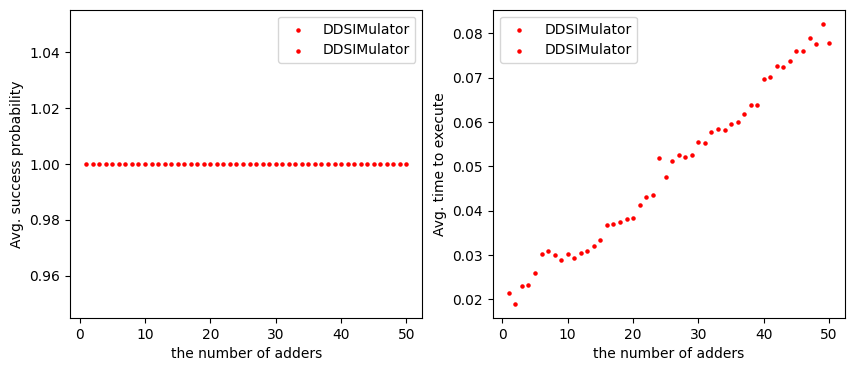

In [35]:
x = [num_qubits for num_qubits, _, _ in ddsim_result]
additional_x = [num_qubits for num_qubits, _, _ in additional_ddsim_result]
new_x = x + additional_x

success_possibilities_ddsim = [success_possibility  for _, success_possibility, _ in ddsim_result]
times_taken_ddsim = [time_taken  for _, _, time_taken in ddsim_result]

additional_success_possibilities_ddsim = [success_possibility  for _, success_possibility, _ in additional_ddsim_result]
additional_times_taken_ddsim = [time_taken  for _, _, time_taken in additional_ddsim_result]

new_success_possibilities_ddsim = success_possibilities_ddsim + additional_success_possibilities_ddsim
new_times_taken_ddsim = times_taken_ddsim + additional_times_taken_ddsim

fig, axes = plt.subplots(ncols=2, figsize=(10,4))

# Success probability
axes[0].scatter(new_x, new_success_possibilities_ddsim, color="red", s=5, label="DDSIMulator")
axes[0].set_xlabel("the number of adders")
axes[0].set_ylabel("Avg. success probability")
axes[0].legend()

# Time taken
axes[1].scatter(new_x, new_times_taken_ddsim, color="red", s=5, label="DDSIMulator")
axes[1].set_xlabel("the number of adders")
axes[1].set_ylabel("Avg. time to execute")
axes[1].legend()

plt.savefig("additional_ddsim_gates.png")

plt.show()